In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [56]:
data = pd.read_csv("datos/monthly-mean-temp.csv")

In [57]:
data.head()

,Month,Temperature
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [58]:
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index('Month', inplace=True)


In [59]:
print(data.head())
print(data.index)


            Temperature
Month                  
1920-01-01         40.6
1920-02-01         40.8
1920-03-01         44.4
1920-04-01         46.7
1920-05-01         54.1
DatetimeIndex(['1920-01-01', '1920-02-01', '1920-03-01', '1920-04-01',
               '1920-05-01', '1920-06-01', '1920-07-01', '1920-08-01',
               '1920-09-01', '1920-10-01',
               ...
               '1939-03-01', '1939-04-01', '1939-05-01', '1939-06-01',
               '1939-07-01', '1939-08-01', '1939-09-01', '1939-10-01',
               '1939-11-01', '1939-12-01'],
              dtype='datetime64[ns]', name='Month', length=240, freq=None)


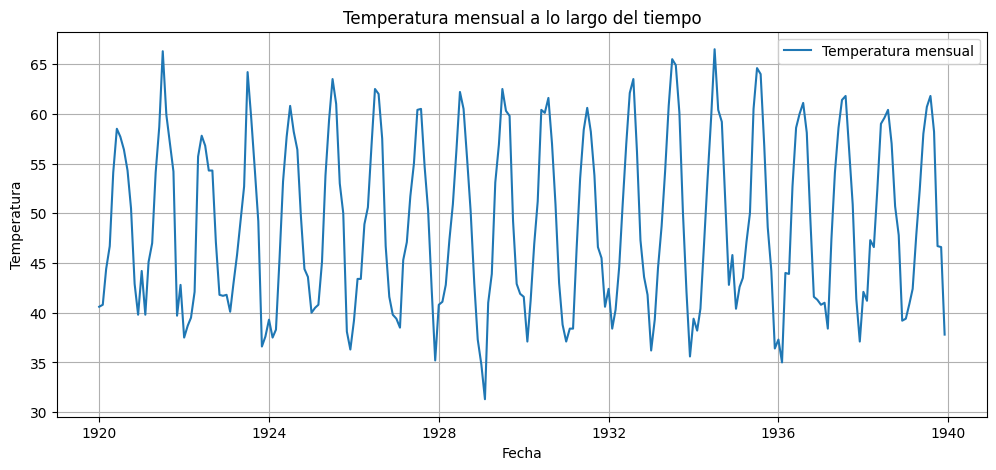

In [60]:
plt.figure(figsize=(12, 5))
plt.plot(data['Temperature'], label='Temperatura mensual')
plt.title('Temperatura mensual a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()

## Análisis Exploratorio

       Temperature
count   240.000000
mean     49.041250
std       8.569705
min      31.300000
25%      41.550000
50%      47.350000
75%      57.000000
max      66.500000
1920-01-01 00:00:00 → 1939-12-01 00:00:00
Temperature    0
dtype: int64


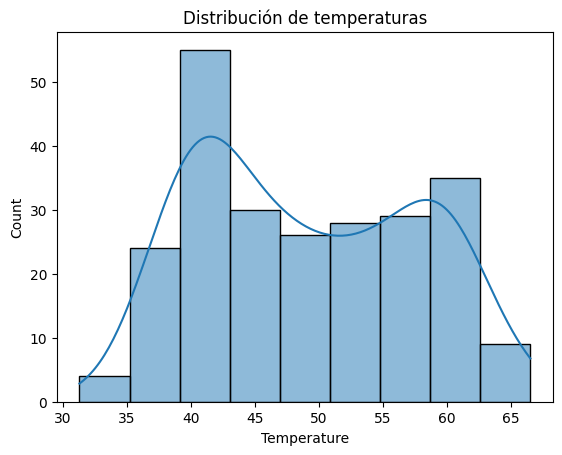

In [61]:
print(data.describe())
print(data.index.min(), '→', data.index.max())
print(data.isnull().sum())

# Gráfico de distribución
sns.histplot(data['Temperature'], kde=True)
plt.title("Distribución de temperaturas")
plt.show()


> - Hay 240 días registrados, van desde el inicio del año **1920**, hasta finales del **1939**
> - Predomina la temperatura entre 39°F y 43°F

## Promedios Móviles

In [62]:
data['MA_3'] = data['Temperature'].rolling(window=3).mean()
data['MA_12'] = data['Temperature'].rolling(window=12).mean()

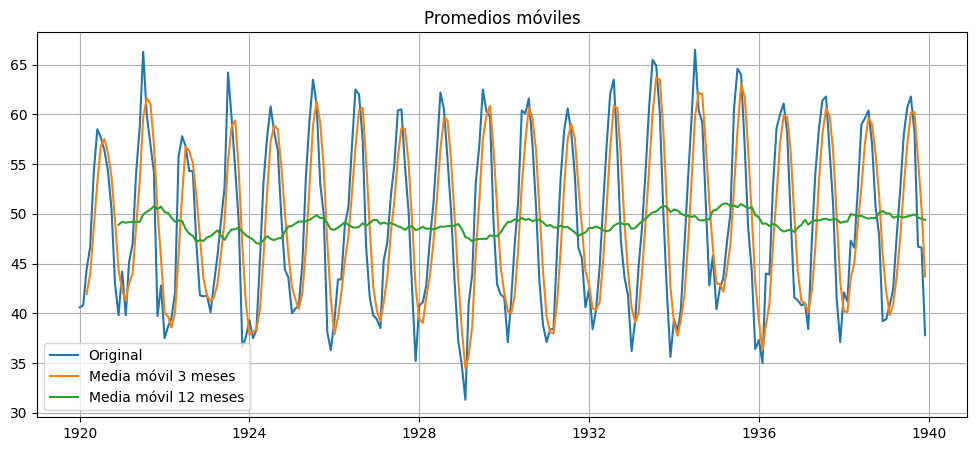

In [63]:

plt.figure(figsize=(12, 5))
plt.plot(data['Temperature'], label='Original')
plt.plot(data['MA_3'], label='Media móvil 3 meses')
plt.plot(data['MA_12'], label='Media móvil 12 meses')
plt.legend()
plt.title('Promedios móviles')
plt.grid(True)
plt.show()

El promedio móvil de 30 días fue aplicado a la serie original de nacimientos. Esta técnica tiene como objetivo reducir la variabilidad diaria y facilitar la observación de patrones generales a lo largo del tiempo. Al eliminar las variaciones más pequeñas, se obtiene una curva que representa de forma más clara la tendencia central del fenómeno.

Al comparar la serie original con su versión suavizada, se puede notar que los datos diarios presentan una alta variabilidad, con picos abruptos y caídas frecuentes. En cambio, la curva del promedio móvil se comporta de manera más estable y continua. Esto permite identificar con mayor claridad periodos de aumento o disminución sostenida en la cantidad de nacimientos.

En particular, la serie suavizada muestra un incremento moderado hacia el último trimestre del año, seguido de una ligera disminución en diciembre. Este tipo de análisis visual puede ser útil para detectar posibles patrones estacionales o contextuales, incluso si no se cuenta con información adicional sobre los factores externos que los explican.

## Aislamiento Exponencial Simple

C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


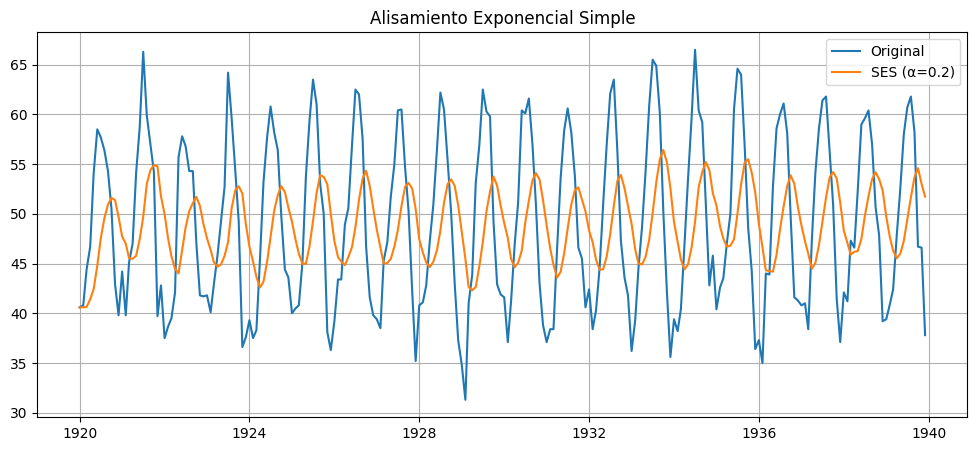

In [64]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model_ses = SimpleExpSmoothing(data['Temperature']).fit(smoothing_level=0.2, optimized=False)
data['SES'] = model_ses.fittedvalues

plt.figure(figsize=(12, 5))
plt.plot(data['Temperature'], label='Original')
plt.plot(data['SES'], label='SES (α=0.2)')
plt.legend()
plt.title('Alisamiento Exponencial Simple')
plt.grid(True)
plt.show()


Este modelo logra capturar y predecir los picos y cambios de temperaturas entre bajas y altas, pero no está prediciendo los valores exáctos, por lo que se manipulará el parámetro de suavizamiento para hallar una mejora.

C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


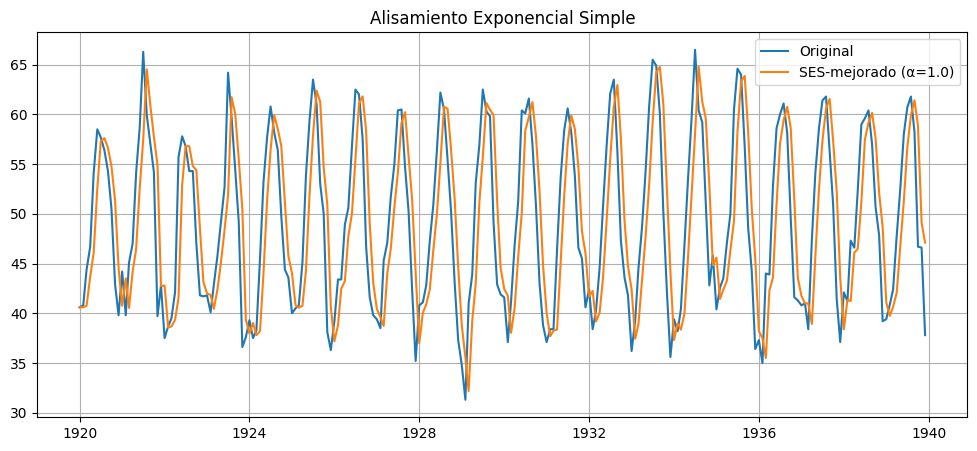

In [82]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model_ses = SimpleExpSmoothing(data['Temperature']).fit(smoothing_level=0.8, optimized=False)
data['SES-mejorado'] = model_ses.fittedvalues

plt.figure(figsize=(12, 5))
plt.plot(data['Temperature'], label='Original')
plt.plot(data['SES-mejorado'], label='SES-mejorado (α=1.0)')
plt.legend()
plt.title('Alisamiento Exponencial Simple')
plt.grid(True)
plt.show()


El modelo, ahora con `α = 1.0`, muestra una mejora notable en comparación con la versión anterior, evidenciando un ajuste visual mucho más cercano a la serie original. No obstante, este comportamiento se logra a costa de sacrificar el propósito principal del alisamiento exponencial, ya que el modelo se comporta casi como una réplica desplazada de los valores observados. Este tipo de configuración podría ser útil en contextos donde no se busca modelar tendencia ni estacionalidad, sino simplemente reaccionar de manera inmediata a los cambios recientes en los datos.

## Holt-Winters

C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


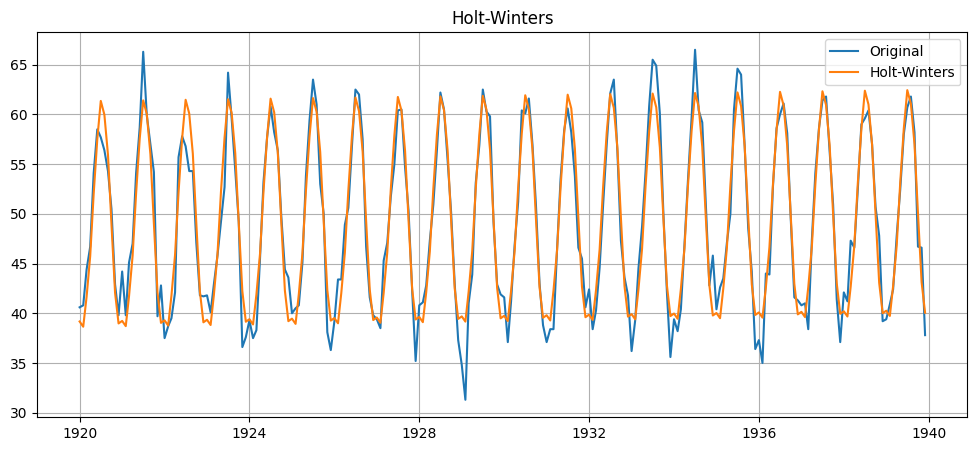

In [66]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Tendencia + estacionalidad
model_hw = ExponentialSmoothing(data['Temperature'], trend='add', seasonal='add', seasonal_periods=12).fit()
data['HW'] = model_hw.fittedvalues

plt.figure(figsize=(12, 5))
plt.plot(data['Temperature'], label='Original')
plt.plot(data['HW'], label='Holt-Winters')
plt.legend()
plt.title('Holt-Winters')
plt.grid(True)
plt.show()

## SARIMA

Primero, para hallar los mejores parámetros, se realizó el siguiente análisis:

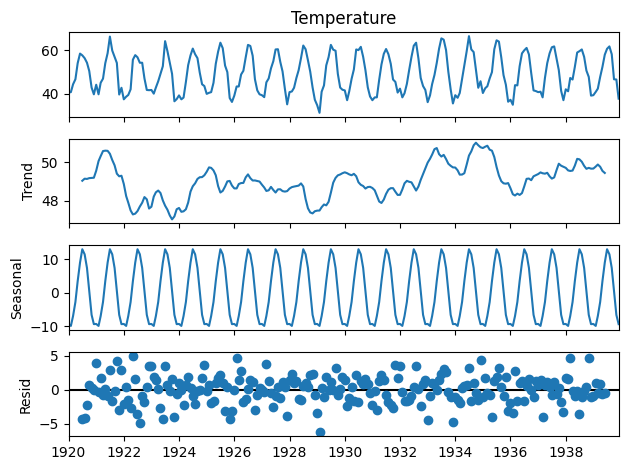

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Temperature'], model='additive', period=12)
result.plot()
plt.show()

Analizando las gráficas, se puede saber que hay **estacionalidad** anual bastante clara debido alos picos en el componente seasonal.

Ahora para estimar los valores `p` y `q`, se crearon las siguientes gráficas:

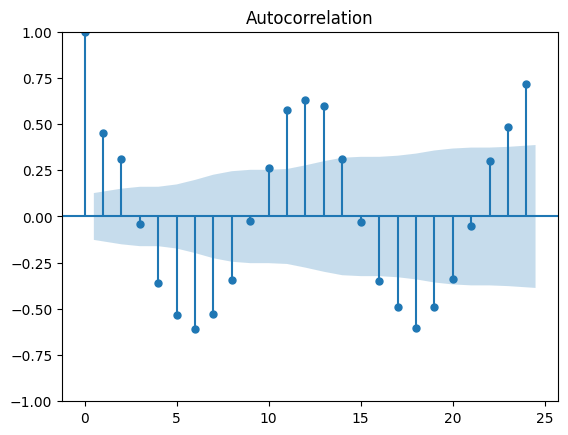

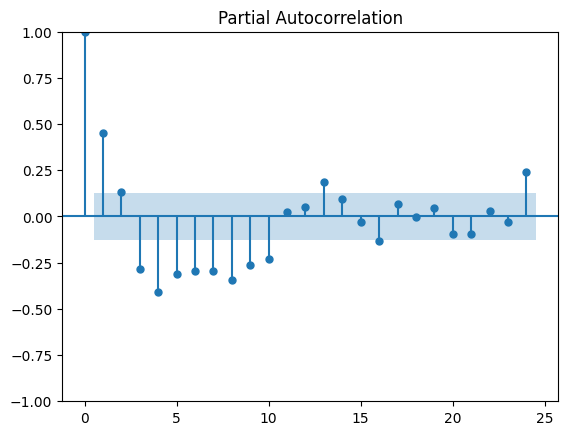

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Temperature'].diff().dropna(), lags=24)
plot_pacf(data['Temperature'].diff().dropna(), lags=24)
plt.show()

Para la gráfica **ACF**, los picos más visibles están en **12** y **24**, lo que nos indica estacionalidad, sugiere que nuestro valor `s` sea `12`. Además por el decaimiento lento de la gráfica, podríamos necesitar una diferenciación de **1**.

Por otro lado, para la gráfica **PACF** se observa que en los rezagos 1 y 2 hay picos significativos, sin embargo luego se corta esta tendencia, indicando un componente AR de orden `p = 2`

C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


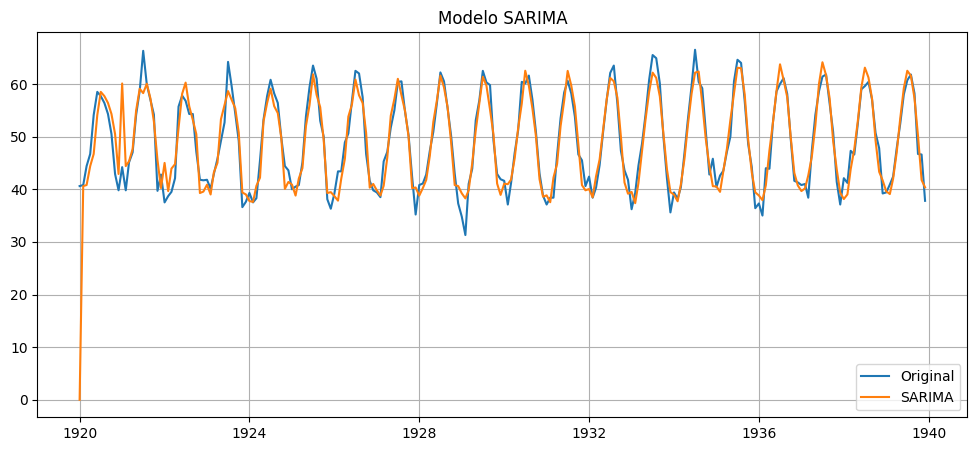

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 2
d = 1
q = 1

P = 1
D = 1
Q = 1
s = 12

model_sarima = SARIMAX(data['Temperature'],order = (p,d,q), seasonal_order=(P,D,Q,s)).fit()
data['SARIMA'] = model_sarima.fittedvalues

plt.figure(figsize=(12, 5))
plt.plot(data['Temperature'], label='Original')
plt.plot(data['SARIMA'], label='SARIMA')
plt.legend()
plt.title('Modelo SARIMA')
plt.grid(True)
plt.show()


## Prophet

01:39:13 - cmdstanpy - INFO - Chain [1] start processing
01:39:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\drkfa\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


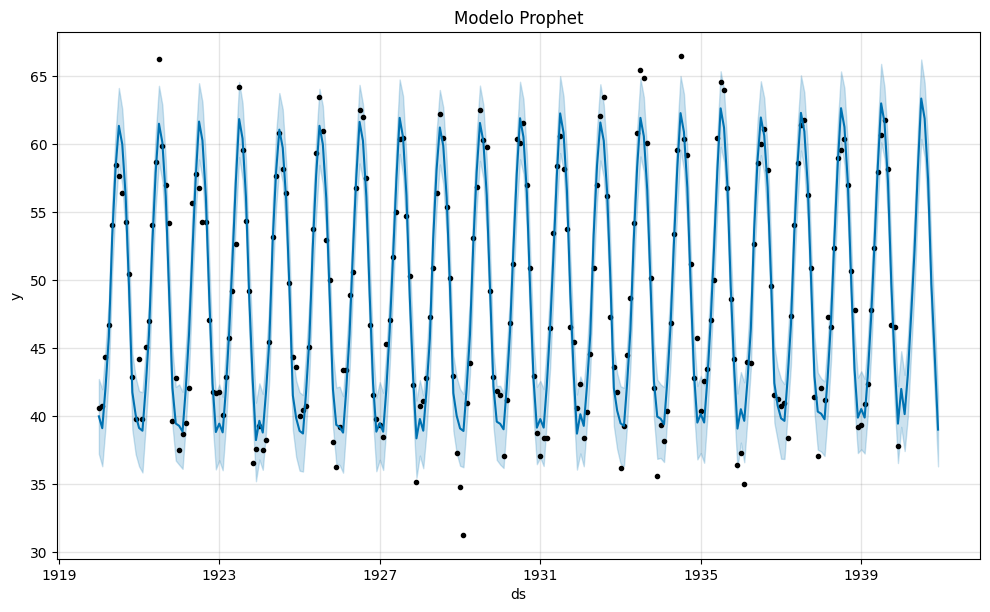

In [70]:
from prophet import Prophet

df_prophet = data.reset_index().rename(columns={'Month': 'ds', 'Temperature': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=12, freq='M')
forecast = model_prophet.predict(future)

# Graficar
model_prophet.plot(forecast)
plt.title('Modelo Prophet')
plt.show()

# Reunir predicciones para comparación
df_prophet['Prophet'] = model_prophet.predict(df_prophet)[['yhat']]
data['Prophet'] = df_prophet.set_index('ds')['Prophet']


## Comparación y Evaluación de Modelos

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluar_modelo(real, predicho):
    mae = mean_absolute_error(real, predicho)
    rmse = np.sqrt(mean_squared_error(real, predicho))
    return mae, rmse

resultados = {
    'SES': evaluar_modelo(data['Temperature'], data['SES']),
    'SES-mejorado': evaluar_modelo(data['Temperature'], data['SES-mejorado']),
    'Holt-Winters': evaluar_modelo(data['Temperature'], data['HW']),
    'SARIMA': evaluar_modelo(data['Temperature'], data['SARIMA']),
    'Prophet': evaluar_modelo(data['Temperature'], data['Prophet'])
}

resultados_df = pd.DataFrame(resultados, index=['MAE', 'RMSE']).T
print(resultados_df.sort_values('RMSE'))


                   MAE      RMSE
Prophet       1.700825  2.186984
Holt-Winters  1.740151  2.230472
SARIMA        2.207448  3.775199
SES-mejorado  4.297500  5.222436
SES           7.711054  8.801335


El modelo que mostró el mejor desempeño fue **Prophet**, al obtener el menor `MAE` y `RMSE`, lo que indica una mayor precisión general y menor sensibilidad a errores extremos. En segundo lugar se encuentra **Holt-Winters**, cuyos resultados fueron similares pero ligeramente inferiores, lo que sugiere que también logra capturar adecuadamente la tendencia y estacionalidad de la serie. El modelo **SARIMA**, incluso ajustando sus parámetros basados en los gráficos ACF y PACF tuvo un desempeño por debajo de *Prophet* y *Holt-Winters*. Esto puede deberse a que el modelo aún no captura completamente la dinámica de la serie, o a que la serie de tiempo se ajusta mejor a métodos no puramente estadísticos. Finalmente, el modelo **SES**, aunque mejoró significativamente tras ajustar el parámetro de suavizamiento α, sigue mostrando un desempeño inferior respecto a los demás modelos evaluados, debido a su incapacidad para capturar componentes como tendencia o estacionalidad.